In [2]:
import pandas as pd
import seaborn as sns
from bitarray import bitarray
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def read_results(dataset, algorithm):
    df = pd.read_csv(f"results/results_{algorithm}_{dataset}.csv", index_col = 0)
    if "Quality" in df.columns:
        df.drop(columns = ["Quality"], inplace = True)
    df["Algorithm"] = algorithm
    df["Dataset"] = dataset
    return df

def get_mimic_data(split:bool):
    if split:
        df_train = pd.read_csv('../data/mimic-iii-train.csv')
        df_test = pd.read_csv('../data/mimic-iii-test.csv')
        df_train = df_train.astype("str")
        df_train.columns = df_train.columns.astype(str)
        df_test = df_test.astype("str")
        df_test.columns = df_test.columns.astype(str)
        return df_train, df_test
    df = pd.read_csv('../data/mimic-iii.csv')
    df = df.astype("str")
    df.columns = df.columns.astype(str)
    return df

def get_mushrooms_data(split:bool):
    if split:
        df_train = pd.read_csv('../data/agaricus-lepiota-train.csv', header = None)
        df_test = pd.read_csv('../data/agaricus-lepiota-test.csv', header = None)
        df_train = df_train.astype("str")
        df_train.columns = [ "poisonous",
        "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
        "gill-attachment", "gill-spacing", "gill-size", "gill-color",
        "stalk-shape", "stalk-root", "stalk-surface-above-ring",
        "stalk-surface-below-ring", "stalk-color-above-ring",
        "stalk-color-below-ring", "veil-type", "veil-color",
        "ring-number", "ring-type", "spore-print-color",
        "population", "habitat"]
        df_test = df_test.astype("str")
        df_test.columns = df_train.columns
        return df_train, df_test
    df = pd.read_csv('../data/agaricus-lepiota.data', header = None)
    df.columns = [ "poisonous",
        "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
        "gill-attachment", "gill-spacing", "gill-size", "gill-color",
        "stalk-shape", "stalk-root", "stalk-surface-above-ring",
        "stalk-surface-below-ring", "stalk-color-above-ring",
        "stalk-color-below-ring", "veil-type", "veil-color",
        "ring-number", "ring-type", "spore-print-color",
        "population", "habitat"]
    df = df.astype("str")
    return df

def get_ab(split: bool = False):
    df = pd.read_csv(f'../data/mimic-iii-preprocessed-db-sample-400.csv')
    df = df.astype("str")
    df.columns = df.columns.astype(str)
    cols = df.columns.to_list()
    cols.remove("culture_susceptibility")
    cols.insert(0, "culture_susceptibility")
    df = df[cols]
    return df


In [4]:
dataframes = {
    "MIMIC" : get_mimic_data(False),
    "Mushrooms" : get_mushrooms_data(False),
    "AB" : get_ab(False)
}


In [5]:
algorithms = ["SDMapStar","BSD","IDSD"]
global_results = pd.DataFrame()
for dataset in dataframes.keys():
    for algorithm in algorithms:
        df = read_results(dataset, algorithm)
        global_results = pd.concat([global_results, df])
global_results.reset_index(drop = True, inplace = True)

In [6]:
global_results.loc[global_results["Algorithm"] == "SDMapStar", "Algorithm"] = "SDMap*"
algorithms = ["SDMap*","BSD","IDSD"]

In [9]:
instances_covered = pd.DataFrame(columns=["Dataset","Algorithm","Instances Covered"])
for dataset in dataframes.keys():
    for algorithm in algorithms:
        df = global_results[(global_results["Dataset"] == dataset) & (global_results["Algorithm"] == algorithm)]
        covered = pd.Series(False, index = dataframes[dataset].index)
        for i,row in df.iterrows():
            description_str = row["Description"]
            description_list = description_str.split(", ")
            # print(f"{description_list}")
            entry = pd.Series(True, index = dataframes[dataset].index)
            for selector in description_list:
                atr = selector.split(" = ")[0]
                val = selector.split(" = ")[1]
                val = val.replace("'", "")
                if val not in dataframes[dataset][atr].unique():
                    print(f"Error: {val} not in {dataframes[dataset][atr].unique()}")
                    continue
                # print(f"<<{selector}>> <<{atr}>> <<{val}>>")
                entry = entry & (dataframes[dataset][atr] == val)
                global_results.loc[i,"Entry"] = "".join([str(int(x)) for x in entry])
            covered = covered | entry
        covered = covered.sum()
        instances_covered.loc[len(instances_covered)] = [dataset, algorithm, covered]


In [11]:
save_flag = False
save_path = ""

Algorithm: SDMap*, Dataset: MIMIC, Min: 0.0, Max: 1.0
Algorithm: BSD, Dataset: MIMIC, Min: 0.0, Max: 1.0
Algorithm: IDSD, Dataset: MIMIC, Min: 0.0, Max: 1.0
Algorithm: SDMap*, Dataset: Mushrooms, Min: 0.583180987202925, Max: 1.0
Algorithm: BSD, Dataset: Mushrooms, Min: 0.4835164835164835, Max: 1.0
Algorithm: IDSD, Dataset: Mushrooms, Min: 0.2545271629778672, Max: 1.0
Algorithm: SDMap*, Dataset: AB, Min: 0.4743935309973046, Max: 1.0
Algorithm: BSD, Dataset: AB, Min: 0.3619402985074627, Max: 1.0
Algorithm: IDSD, Dataset: AB, Min: 0.0, Max: 1.0


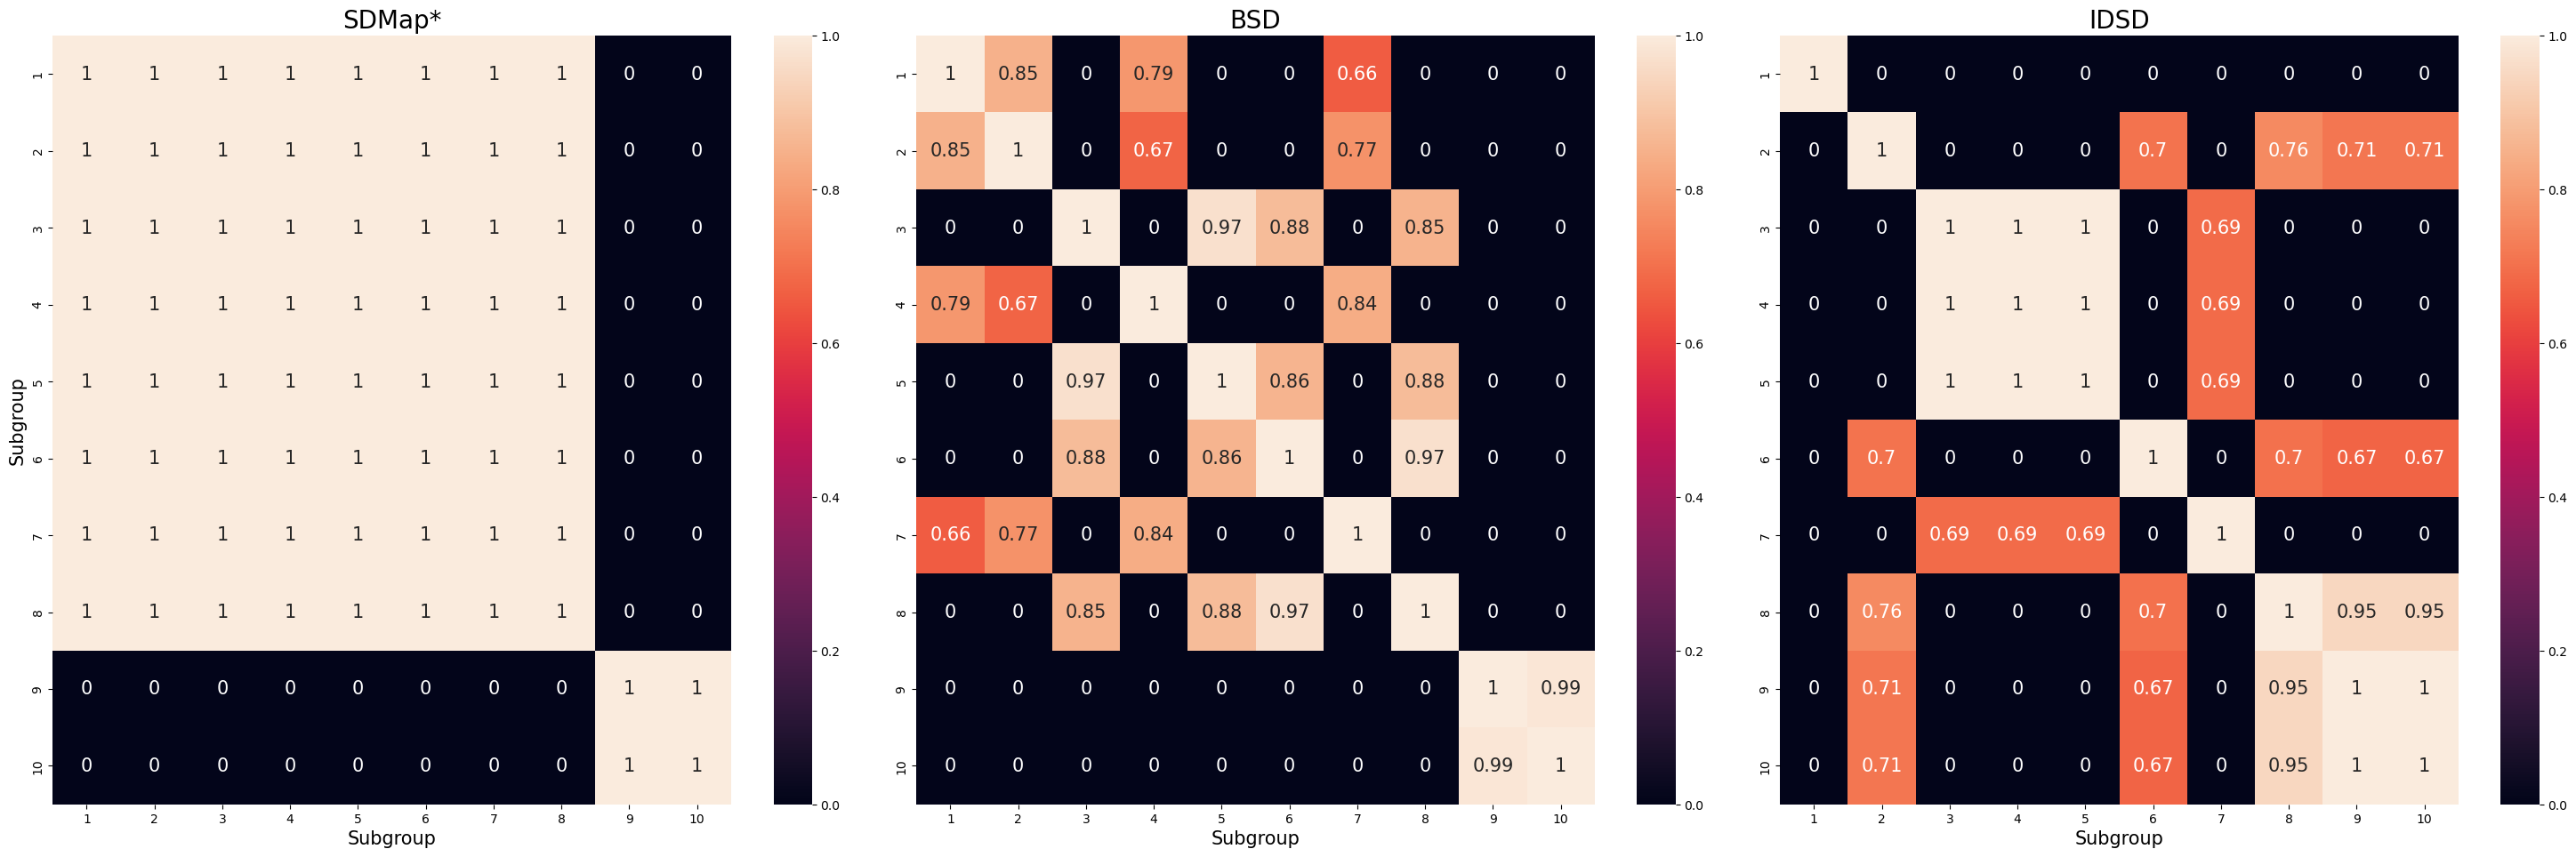

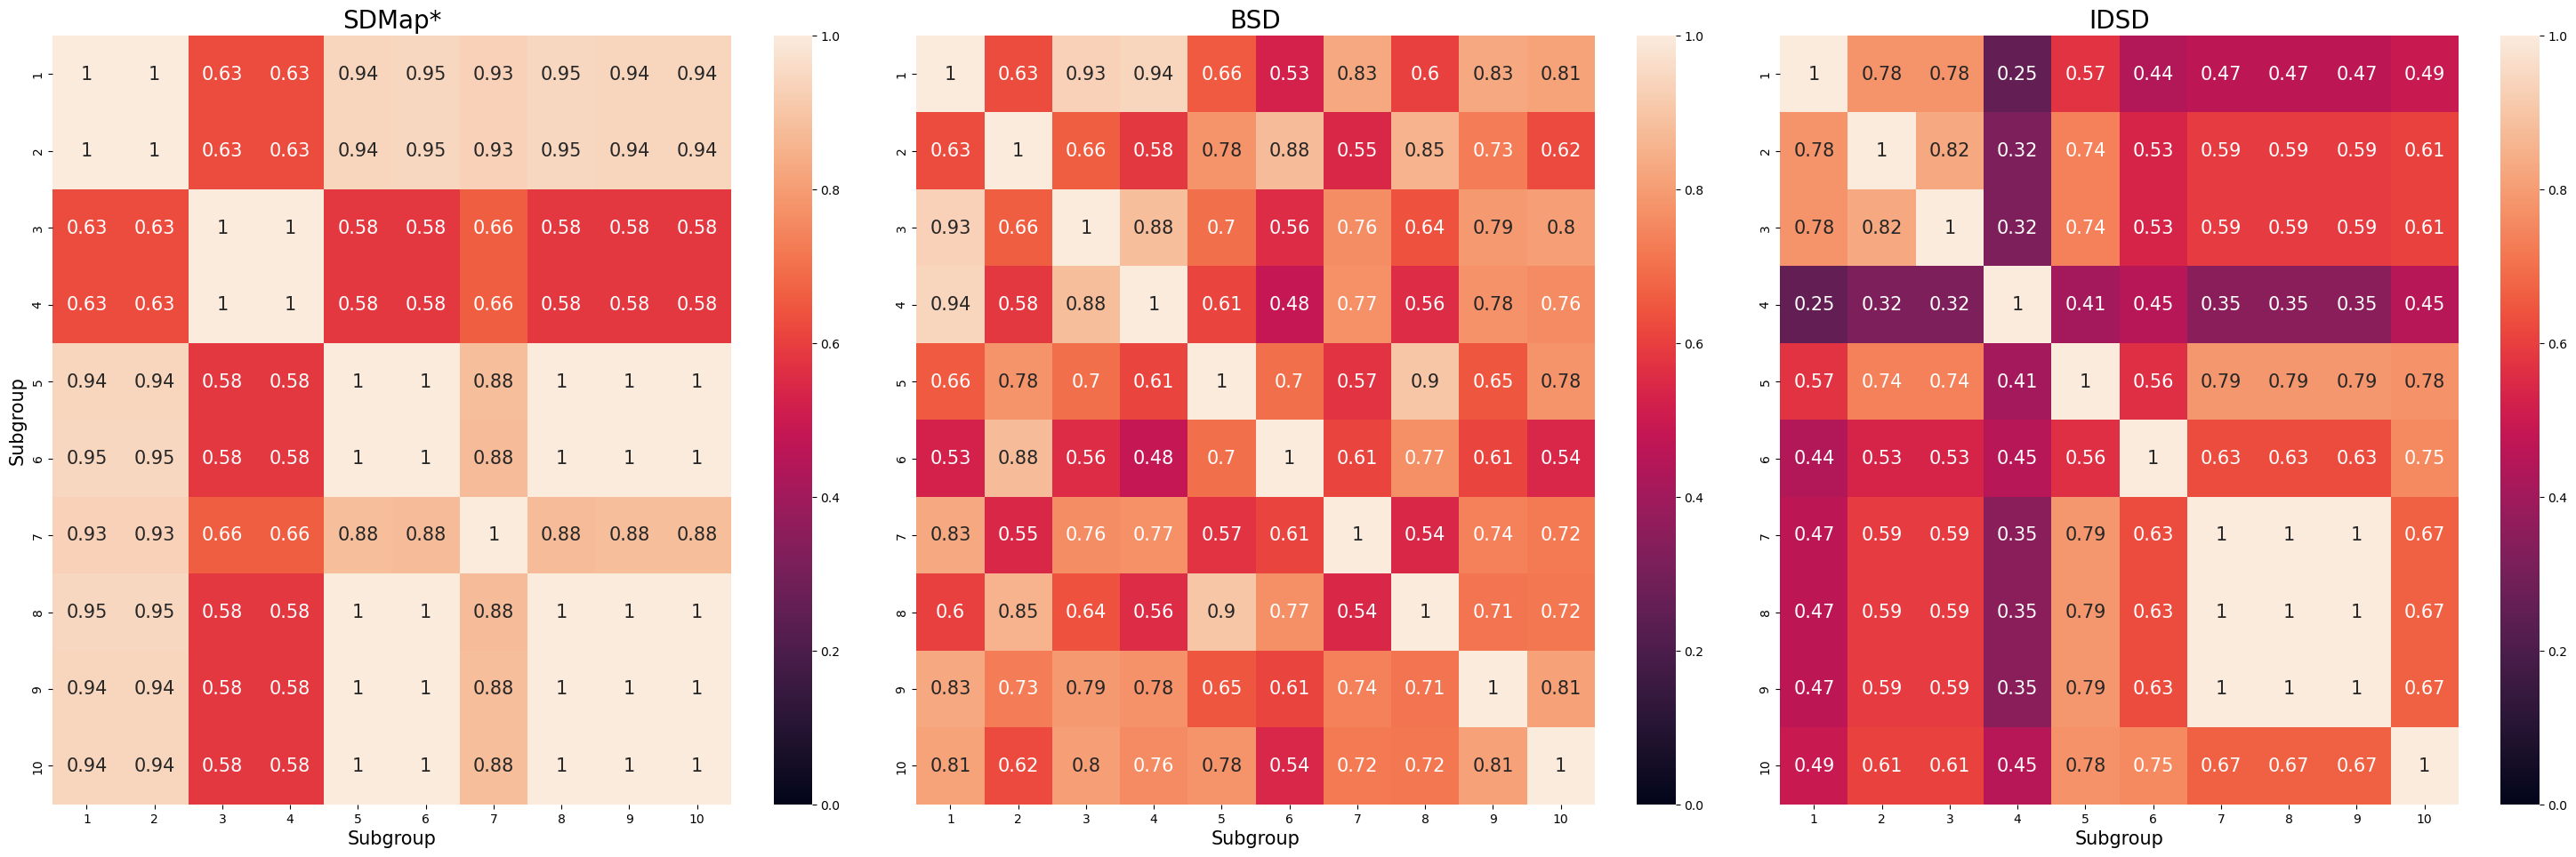

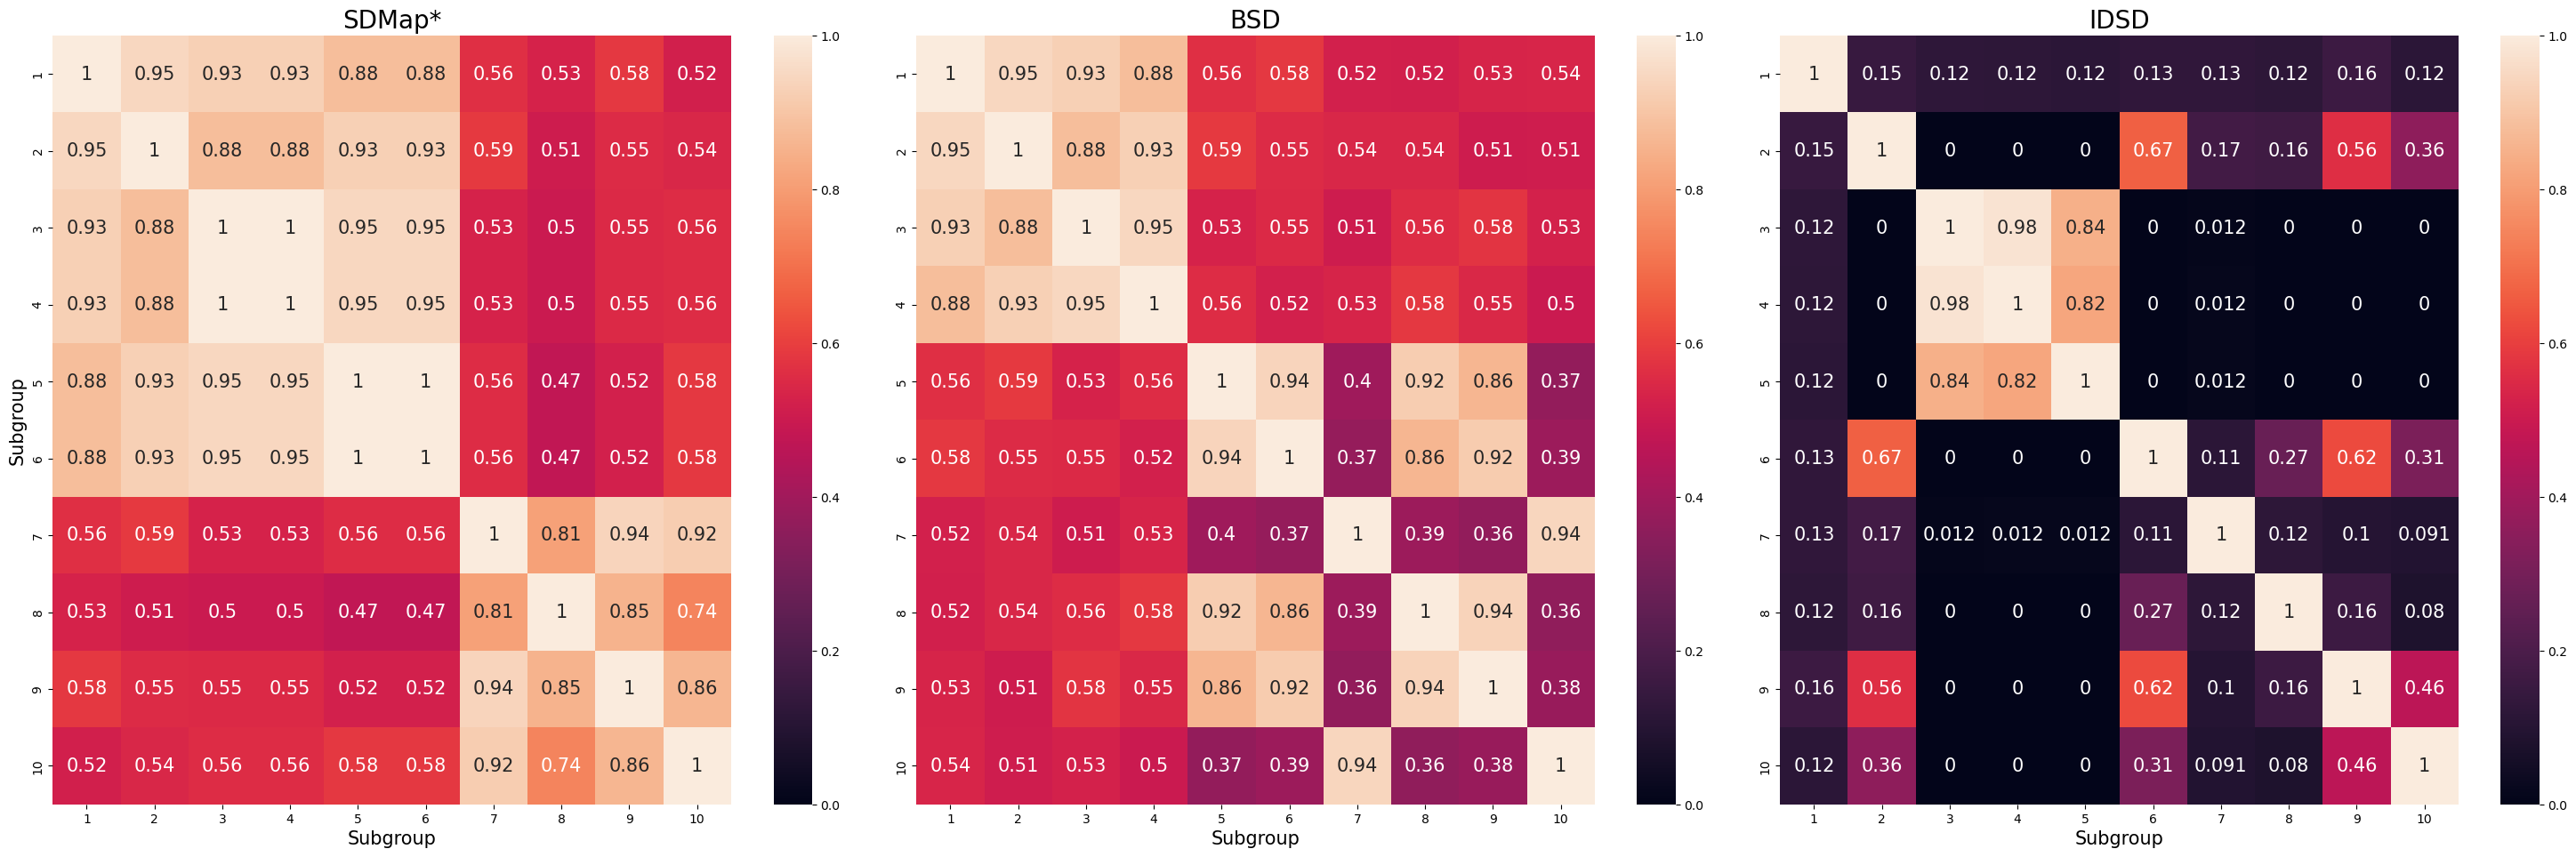

In [13]:
fontsize = 30
for dataset in dataframes.keys():
    fig, ax = plt.subplots(1,3, figsize = (30,10))
    for algorithm in algorithms:
        axis = ax[algorithms.index(algorithm)]
        df = global_results[(global_results["Dataset"] == dataset) & (global_results["Algorithm"] == algorithm)]
        df = df.copy()
        df.reset_index(drop = True, inplace = True)
        overlap_matrix = np.zeros((len(df),len(df)))
        for i,row in df.iterrows():
            for j,row2 in df.iterrows():
                entry1 = bitarray(row["Entry"])
                entry2 = bitarray(row2["Entry"])
                overlap = entry1 & entry2
                jaccard = sum(overlap)/sum(entry1 | entry2)
                overlap_matrix[i,j] = jaccard
        #heat map between 1 and 0
        sns.heatmap(overlap_matrix, annot=True, vmin = 0, vmax = 1, ax = axis,annot_kws={"fontsize":fontsize*0.5})
        axis.set_xticklabels(list(range(1,len(df)+1)))
        axis.set_yticklabels(list(range(1,len(df)+1)))
        axis.set_title(f"{algorithm}", fontsize = fontsize*2)
        axis.set_xlabel("Subgroup", fontsize = fontsize*0.5)
        if algorithms.index(algorithm) == 0:
            axis.set_ylabel("Subgroup", fontsize = fontsize*0.5)
        # Increase title font size
        axis.title.set_size(20)
        print(f"Algorithm: {algorithm}, Dataset: {dataset}, Min: {overlap_matrix.min()}, Max: {overlap_matrix.max()}")
    if save_flag:
        plt.subplots_adjust(top=0.85)
        plt.savefig(f"{save_path}/desc_{dataset}.png", bbox_inches = "tight")
    fig.tight_layout(pad = 2)

Algorithm: SDMap*, Dataset: MIMIC, Min: 0.0, Max: 1.0
Algorithm: BSD, Dataset: MIMIC, Min: 0.0, Max: 1.0
Algorithm: IDSD, Dataset: MIMIC, Min: 0.0, Max: 1.0
Algorithm: SDMap*, Dataset: Mushrooms, Min: 0.583180987202925, Max: 1.0
Algorithm: BSD, Dataset: Mushrooms, Min: 0.4835164835164835, Max: 1.0
Algorithm: IDSD, Dataset: Mushrooms, Min: 0.2545271629778672, Max: 1.0
Algorithm: SDMap*, Dataset: AB, Min: 0.4743935309973046, Max: 1.0
Algorithm: BSD, Dataset: AB, Min: 0.3619402985074627, Max: 1.0
Algorithm: IDSD, Dataset: AB, Min: 0.0, Max: 1.0


/var/folders/8t/9k67z5kn5ng1kb2fsdyc_v0r0000gn/T/ipykernel_27506/2966199626.py:49: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.85)


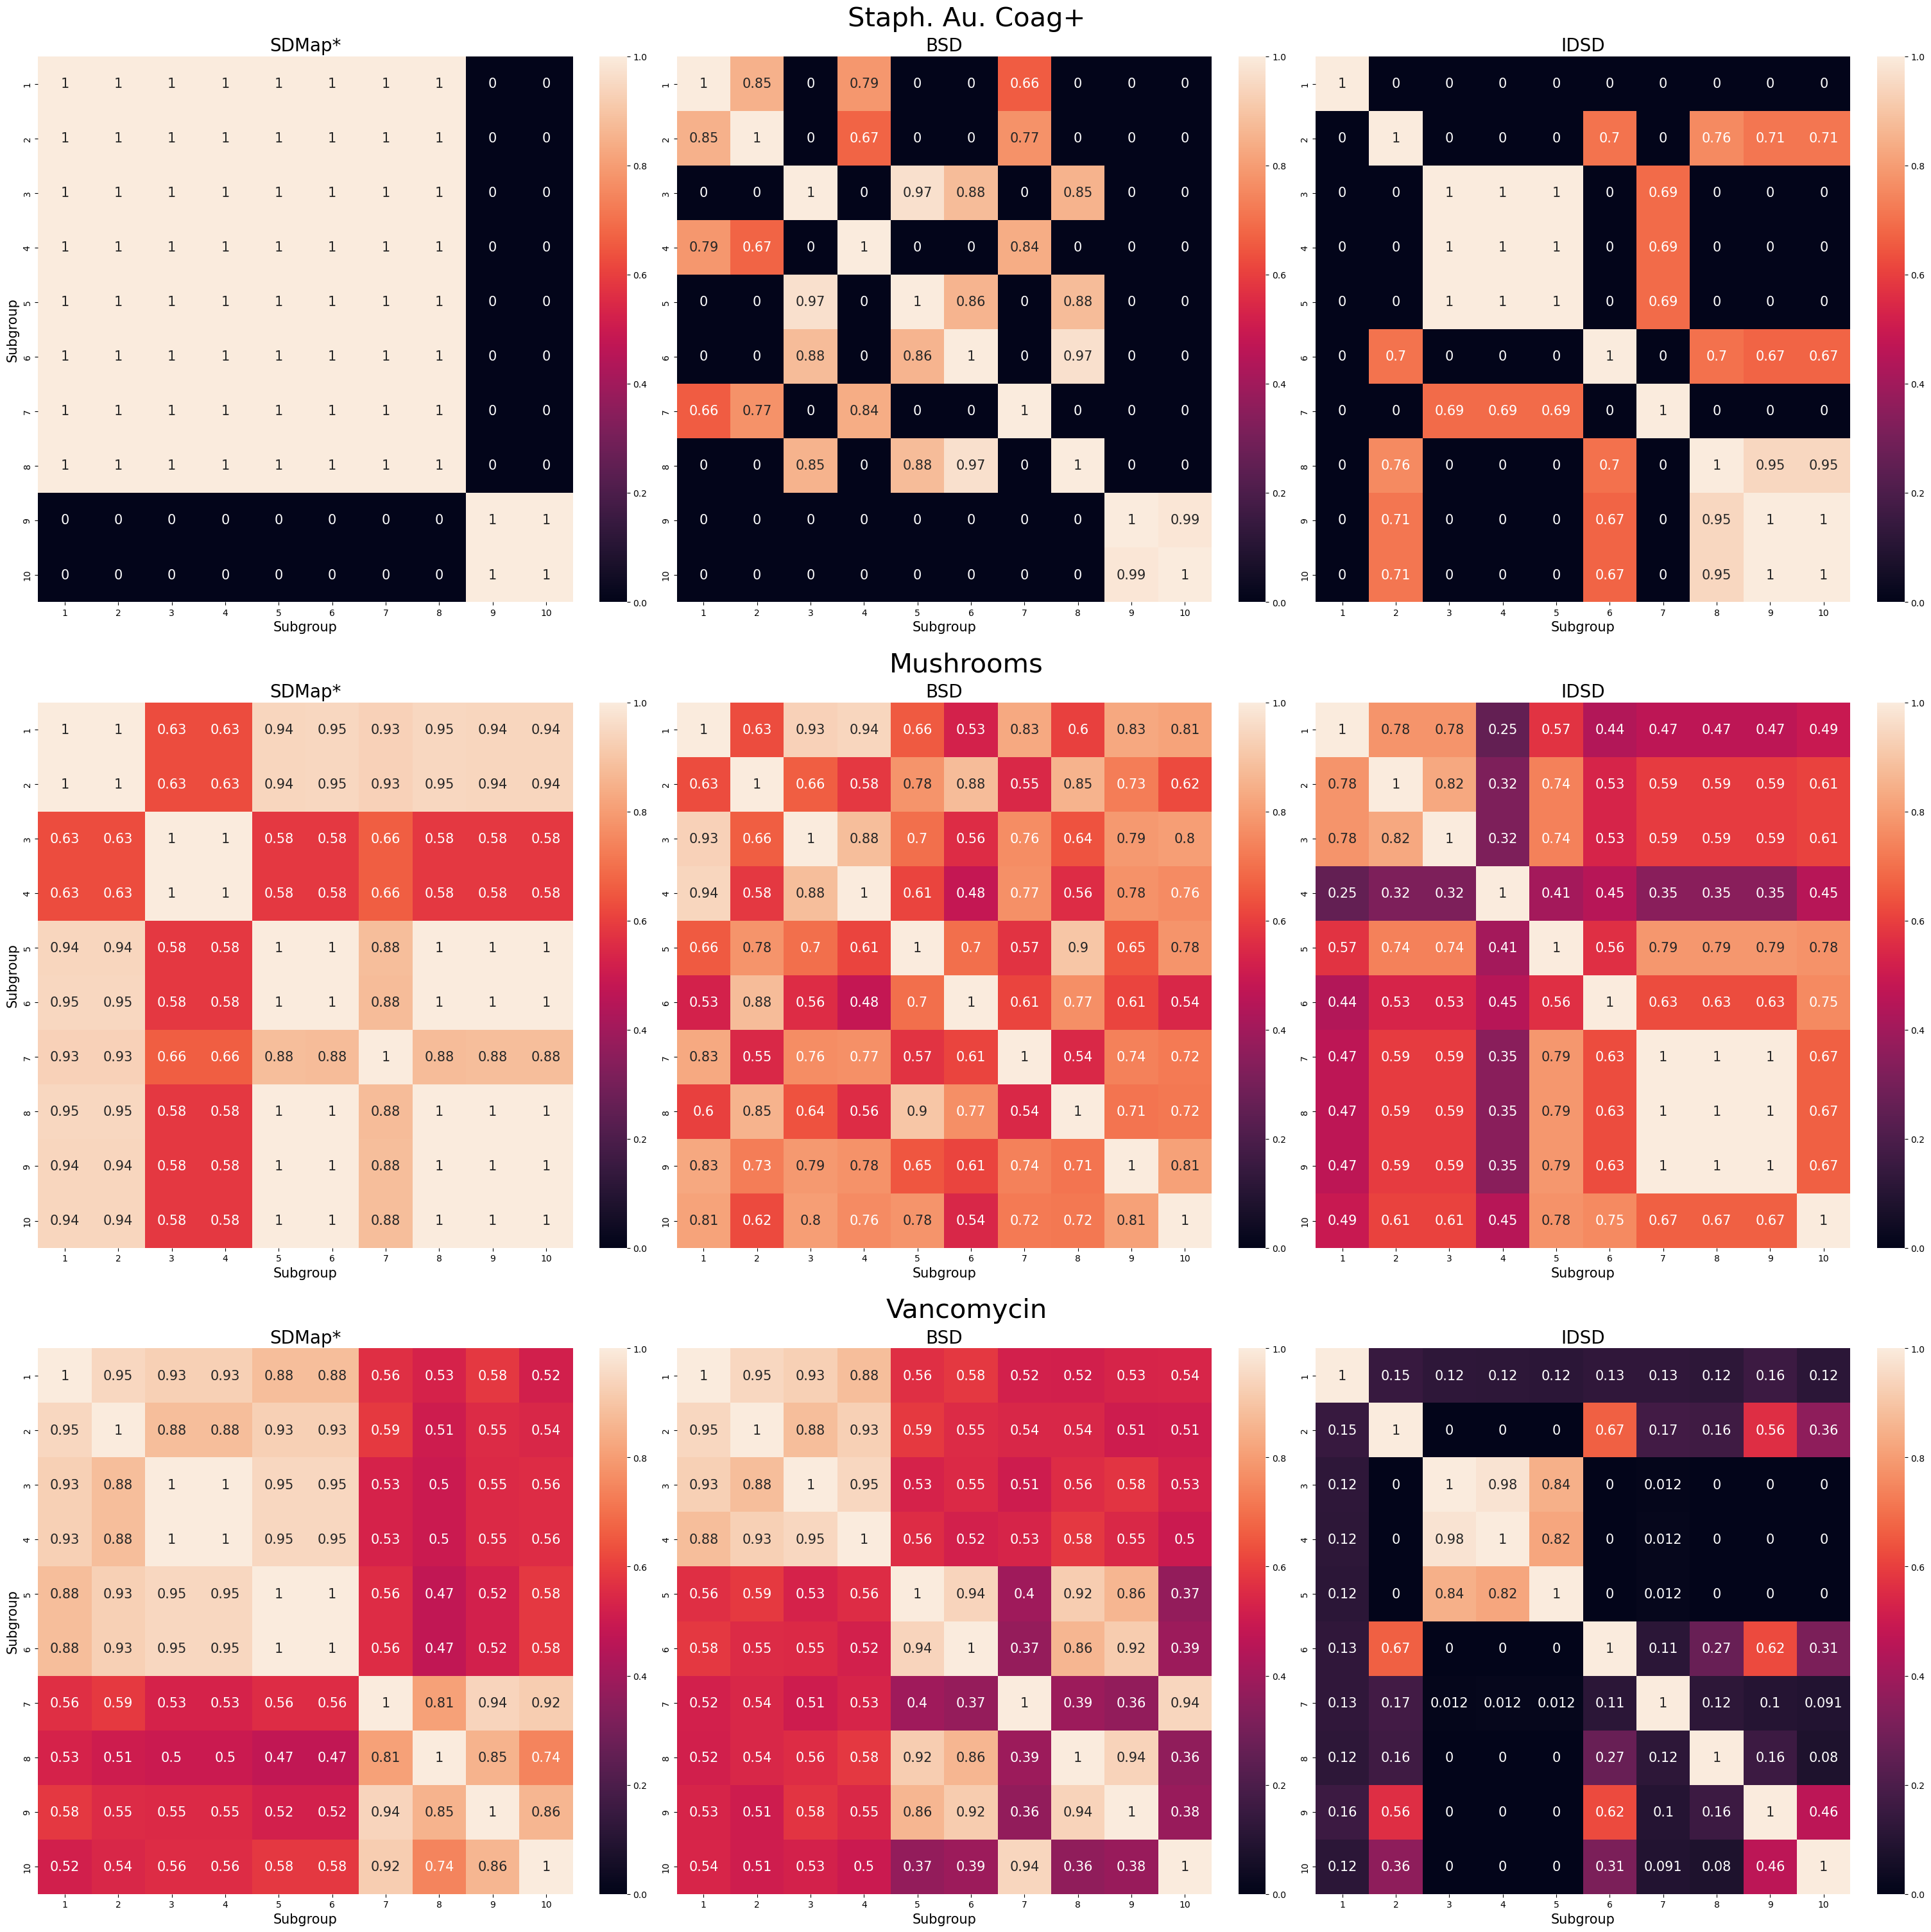

In [20]:
fontsize = 30
fig = plt.figure(constrained_layout=True, figsize=(30, 30))
subfigs = fig.subfigures(nrows=3, ncols=1)


for row, subfig in enumerate(subfigs):
    dataset = list(dataframes.keys())[row]
    subfig.suptitle(dataset, fontsize=fontsize)
    if dataset == "AB":
        subfig.suptitle("Vancomycin", fontsize=fontsize)
    elif dataset == "MIMIC":
        subfig.suptitle("Staph. Au. Coag+", fontsize=fontsize)
    ax = subfig.subplots(1, 3)
    for algorithm in algorithms:
        axis = ax[algorithms.index(algorithm)]
        df = global_results[(global_results["Dataset"] == dataset) & (global_results["Algorithm"] == algorithm)]
        df = df.copy()
        df.reset_index(drop = True, inplace = True)
        overlap_matrix = np.zeros((len(df),len(df)))
        for i,row in df.iterrows():
            for j,row2 in df.iterrows():
                entry1 = bitarray(row["Entry"])
                entry2 = bitarray(row2["Entry"])
                overlap = entry1 & entry2
                jaccard = sum(overlap)/sum(entry1 | entry2)
                overlap_matrix[i,j] = jaccard
        #heat map between 1 and 0
        sns.heatmap(overlap_matrix, annot=True, vmin = 0, vmax = 1, ax = axis,annot_kws={"fontsize":fontsize*0.5})
        axis.set_xticklabels(list(range(1,len(df)+1)))
        axis.set_yticklabels(list(range(1,len(df)+1)))
        axis.set_title(f"{algorithm}", fontsize = fontsize*2)
        axis.set_xlabel("Subgroup", fontsize = fontsize*0.5)
        if algorithms.index(algorithm) == 0:
            axis.set_ylabel("Subgroup", fontsize = fontsize*0.5)
        # Increase title font size
        axis.title.set_size(20)
        print(f"Algorithm: {algorithm}, Dataset: {dataset}, Min: {overlap_matrix.min()}, Max: {overlap_matrix.max()}")
if save_flag:
    plt.subplots_adjust(top=0.85)
    plt.savefig(f"{save_path}/combined_plots.png", bbox_inches = "tight")
